In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from labjackcontroller.labtools import LabjackReader

from multiprocessing.managers import BaseManager
from multiprocessing import Process

import time

In [2]:
device_type = "T7"
connection_type = "ETHERNET"
duration = 18
channels = ["AIN0", "AIN1", "AIN2", "AIN3"]
voltages = [10.0, 10.0, 10.0, 10.0]

In [3]:
def backup(labjack: LabjackReader, filename: str, num_seconds: int) -> None:
    """
    Backup data real-time to a pickle.

    Parameters
    ----------
    labjack: LabjackReader
        A LabjackReader that is collecting data at the
        time of this function's call.
    filename: str
        The name of the file to write to.
        If it does not exist yet, it will be created.
    num_seconds: int
        The number of seconds to try real-time backup.
        After this time, write any remaining data in
        the labjack's buffer.

    Returns
    -------
    None

    """
    start_time = time.time()
    # Write data until time is up.
    while time.time() - start_time <= num_seconds:
        if not (time.time() - start_time) % 60:
            print("Backup at", time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
            labjack.to_dataframe().to_pickle(filename)

In [4]:
BaseManager.register('LabjackReader', LabjackReader)
manager = BaseManager()
manager.start()

# Instantiate a shared LabjackReader
my_lj = manager.LabjackReader(device_type, connection=connection_type)

# Find the maximum frequency that we can safely run at.
freq, packet_size = my_lj.find_max_freq(channels, voltages, num_seconds=5)

[PASS] Finished a stream with an effective scan rate of   100 Hz @     1 scans / packet; buffer had at most   0 items remaining. Frequency search range is now [  100,   200]. There were 0 skips. LJM max size was 0
[PASS] Finished a stream with an effective scan rate of   150 Hz @     1 scans / packet; buffer had at most   0 items remaining. Frequency search range is now [  150,   300]. There were 0 skips. LJM max size was 0
[PASS] Finished a stream with an effective scan rate of   225 Hz @     1 scans / packet; buffer had at most   0 items remaining. Frequency search range is now [  225,   450]. There were 0 skips. LJM max size was 0
[PASS] Finished a stream with an effective scan rate of   338 Hz @     1 scans / packet; buffer had at most   0 items remaining. Frequency search range is now [  337,   675]. There were 0 skips. LJM max size was 0
[PASS] Finished a stream with an effective scan rate of   506 Hz @     1 scans / packet; buffer had at most   0 items remaining. Frequency searc

[FAIL] Finished a stream with an effective scan rate of 18657 Hz @  2048 scans / packet; buffer had at most   5 items remaining. Frequency search range is now [17840, 19461]. There were 0 skips. LJM max size was 0
[FAIL] Finished a stream with an effective scan rate of 18657 Hz @  4096 scans / packet; buffer had at most   5 items remaining. Frequency search range is now [17840, 19461]. There were 0 skips. LJM max size was 0
[FAIL] Finished a stream with an effective scan rate of 18657 Hz @  8192 scans / packet; buffer had at most   5 items remaining. Frequency search range is now [17840, 19461]. There were 0 skips. LJM max size was 0
[FAIL] Finished a stream with an effective scan rate of 18657 Hz @ 16384 scans / packet; buffer had at most   5 items remaining. Frequency search range is now [17840, 19461]. There were 0 skips. LJM max size was 0
[FAIL] Finished a stream with an effective scan rate of 18248 Hz @     8 scans / packet; buffer had at most   1 items remaining. Frequency searc

[FAIL] Finished a stream with an effective scan rate of 17953 Hz @  8192 scans / packet; buffer had at most   5 items remaining. Frequency search range is now [17840, 18042]. There were 0 skips. LJM max size was 0
[FAIL] Finished a stream with an effective scan rate of 17953 Hz @ 16384 scans / packet; buffer had at most   5 items remaining. Frequency search range is now [17840, 18042]. There were 0 skips. LJM max size was 0
[FAIL] Finished a stream with an effective scan rate of 17921 Hz @     8 scans / packet; buffer had at most   1 items remaining. Frequency search range is now [17840, 17941]. There were 0 skips. LJM max size was 0
[FAIL] Finished a stream with an effective scan rate of 17921 Hz @    16 scans / packet; buffer had at most   1 items remaining. Frequency search range is now [17840, 17941]. There were 0 skips. LJM max size was 0
[FAIL] Finished a stream with an effective scan rate of 17921 Hz @    32 scans / packet; buffer had at most   1 items remaining. Frequency searc

[PASS] Finished a stream with an effective scan rate of 17857 Hz @     8 scans / packet; buffer had at most   0 items remaining. Frequency search range is now [17846, 17852]. There were 0 skips. LJM max size was 0
[PASS] Finished a stream with an effective scan rate of 17857 Hz @     8 scans / packet; buffer had at most   0 items remaining. Frequency search range is now [17849, 17852]. There were 0 skips. LJM max size was 0
[PASS] Finished a stream with an effective scan rate of 17857 Hz @     8 scans / packet; buffer had at most   0 items remaining. Frequency search range is now [17851, 17852]. There were 0 skips. LJM max size was 0
LabjackReader('Type': T7, Connection': Ethernet, 'Serial': 470014713, 'IP': 169.254.175.73, 'Port': 502) Max packet size in bytes: 1040


In [5]:
# Declare a data-gathering process
data_proc = Process(target=my_lj.collect_data,
                    args=(channels, voltages, duration, freq),
                    kwargs={'resolution': 0,
                            'sample_rate': packet_size})


# Declare a data backup process
backup_proc = Process(target=backup, args=(my_lj, "backup.pkl",
                                           duration))

# Start all threads, and join when finished.
data_proc.start()
backup_proc.start()

data_proc.join()
backup_proc.join()

In [6]:
# For testing purposes, print rows 400 to 500.
my_lj.to_dataframe(mode="range", start=400, end=500)

,AIN0,AIN1,AIN2,AIN3,Time,System Time
0,-0.484500,-4.669583,-5.102262,-6.946905,0.022440,0.015477
1,-0.484500,-4.668636,-5.101631,-6.946905,0.022496,0.015479
2,-0.484500,-4.670215,-5.102577,-6.947220,0.022552,0.015481
3,-0.484500,-4.669583,-5.101946,-6.946905,0.022608,0.015483
4,-0.484816,-4.668321,-5.101631,-6.946589,0.022664,0.015485
5,-0.484816,-4.670215,-5.102262,-6.946589,0.022720,0.015486
6,-0.485131,-4.669583,-5.101946,-6.947220,0.022777,0.015488
7,-0.484500,-4.670215,-5.101946,-6.946274,0.022833,0.015490
8,-0.484816,-4.668636,-5.101946,-6.945642,0.022889,0.015995
9,-0.484816,-4.670530,-5.102577,-6.947852,0.022945,0.015998


In [7]:
datarun = my_lj.to_dataframe()

In [8]:
datarun.rename(index=str, columns={"AIN0": "L-R", "AIN1": "T-B", "AIN2": "SUM", "AIN3": "TEMP"}, inplace=True)

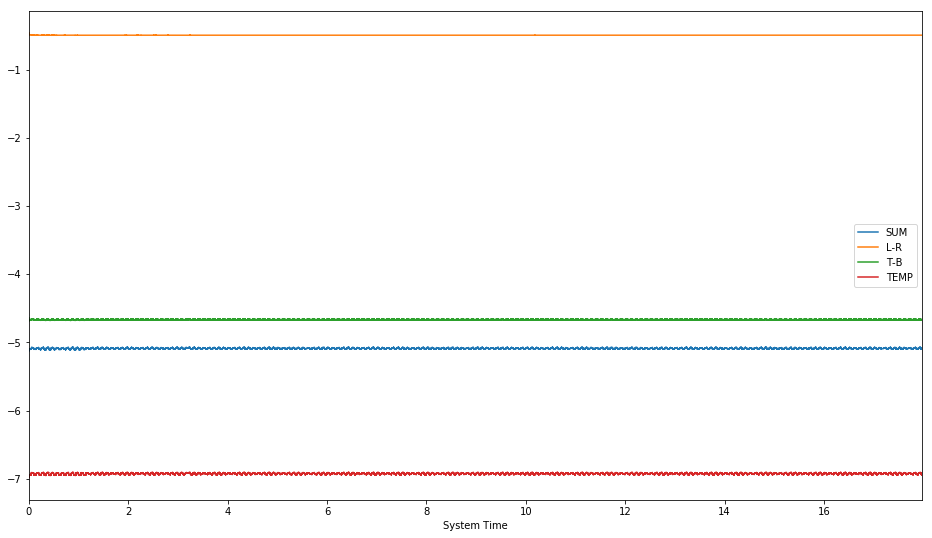

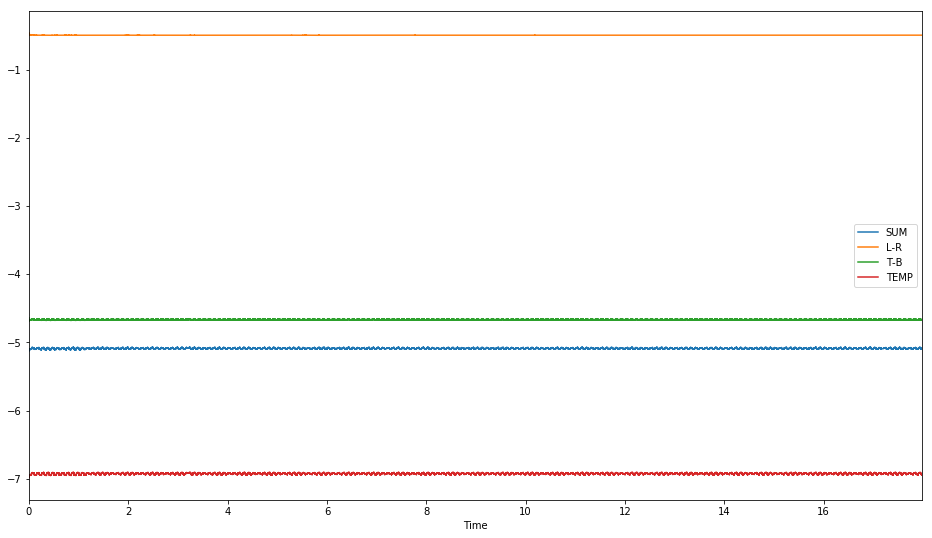

In [9]:
datarun[['SUM', 'L-R', 'T-B', 'TEMP', 'System Time']].plot(figsize=(16, 9), x='System Time')
plt.show()

datarun[['SUM', 'L-R', 'T-B', 'TEMP', 'Time']].plot(figsize=(16, 9), x='Time')
plt.show()

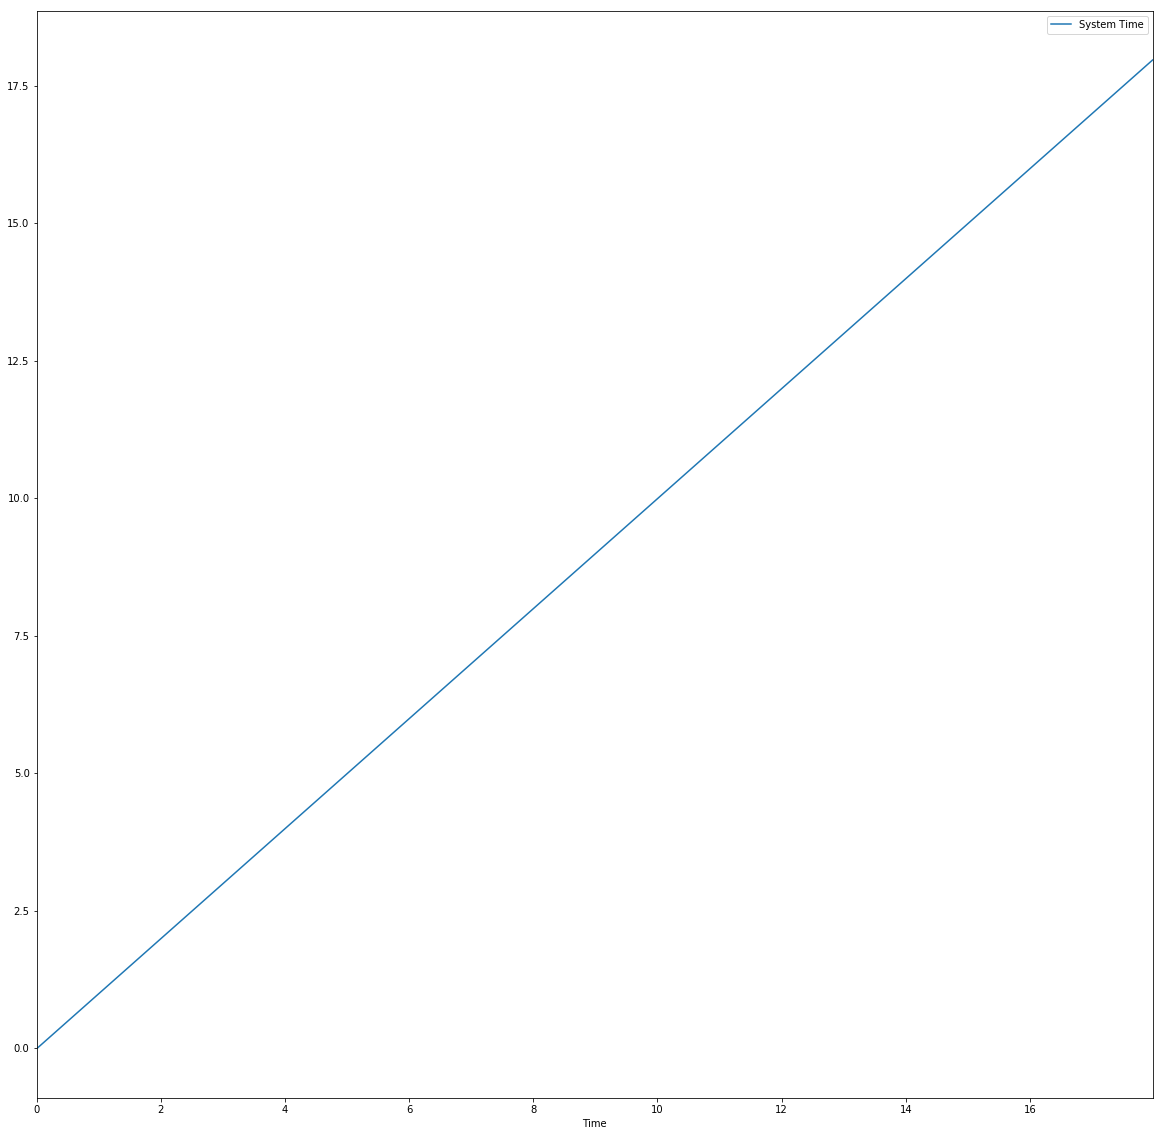

In [10]:
datarun[['Time', 'System Time']].plot(figsize=(20, 20), x='Time', y='System Time')